In [1]:
#Mount my google drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split


review_data = load_files(r"drive/My Drive/machine_learning_data/assignment11/movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
m = len(X_train.T)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
X_train.shape

(1401, 1500)

In [4]:
X_test.shape

(601, 1500)

In [5]:
# One Hot encoding Y
labelCheck = y_train
nb_classes = 2
targets = y_train.reshape(-1)
label = np.eye(nb_classes)[targets]

# One Hot encoding Y test
testLabelCheck = y_test
nb_classes = 2
testTargets = y_test.reshape(-1)
testLabel = np.eye(nb_classes)[testTargets]
testLabel.shape

(601, 2)

In [6]:
# Initialize uMatrix, vMatrix, wMatrix

uMatrix = np.random.randn(300, 1500) * np.sqrt(np.sqrt(1/1500))
vMatrix = np.random.randn(50, 300) * np.sqrt(np.sqrt(1/300))
wMatrix = np.random.randn(2, 50) * np.sqrt(np.sqrt(1/50))

# uMatrix = np.random.normal(0, 1, size=(300, 1500))
# vMatrix = np.random.normal(0, 1, size=(50, 300))
# wMatrix = np.random.normal(0, 1, size=(2, 50))

thetaSize = (300 * 1500) + (50 * 300) + (2 * 50)

loss = 0
lossTest = 0

# Initialize y, z, h matrix
def create0Matrix(m, n):
  result = []
  for i in range(m):
    temp = []
    for j in range(n):
      temp.append(0)
    result.append(temp)
  return np.array(result, dtype='float64')

biasU = create0Matrix(300, 1)
biasV = create0Matrix(50, 1)
biasW = create0Matrix(2, 1)

yMatrix = create0Matrix(300, 1401)
ySigmoidMatrix = create0Matrix(300, 1401)

yTestMatrix = create0Matrix(300, 601)
yTestSigmoidMatrix = create0Matrix(300, 601)

zMatrix = create0Matrix(50, 1401)
zSigmoidMatrix = create0Matrix(50, 1401)

zTestMatrix = create0Matrix(50, 601)
zTestSigmoidMatrix = create0Matrix(50, 601)

hMatrix = create0Matrix(2, 1401)
hSigmoidMatrix = create0Matrix(2, 1401)

hTestMatrix = create0Matrix(2, 601)
hTestSigmoidMatrix = create0Matrix(2, 601)

uMatrix.shape

print(uMatrix)

[[ 0.15447953 -0.09329952 -0.21588442 ...  0.21579448  0.34916709
   0.09757244]
 [-0.29920347  0.01317566  0.2563024  ...  0.16249308  0.16358989
   0.10823069]
 [-0.22991897  0.10536358 -0.09830143 ...  0.0022451  -0.0969298
  -0.03003989]
 ...
 [ 0.04959925  0.28210997 -0.0476481  ...  0.09499015 -0.09144646
  -0.24123584]
 [-0.06026408  0.0549784  -0.23000467 ...  0.00182704  0.15690349
   0.13520239]
 [ 0.09164659  0.1745177   0.05429278 ... -0.02632678  0.05312886
   0.12728583]]


In [7]:
# Functions 
def sigmaFunc(inputMatrix):
  return np.array(1 / (1 + np.exp(-1 * inputMatrix)),dtype='float64')

def lossFunc(inputMatrix):
  return 1/m * np.sum( ((-1 * label.T) * np.log(inputMatrix)) - ((1-label.T) * np.log(1-inputMatrix)))

def lossTestFunc(inputMatrix):
  return 1/m * np.sum( ((-1 * testLabel.T) * np.log(inputMatrix)) - ((1-testLabel.T) * np.log(1-inputMatrix))) + regularizeLamda / thetaSize * (np.sum(uMatrix) + np.sum(wMatrix) + np.sum(vMatrix))

def derivateH():
  return (1 / m) * (hSigmoidMatrix - label.T)

def derivateV():
  return np.matmul(wMatrix.T, derivateH()) * zSigmoidMatrix * (1 - zSigmoidMatrix)

def derivateU():
  return np.matmul(vMatrix.T, derivateV()) * ySigmoidMatrix * (1 - ySigmoidMatrix)

In [8]:
# Learning Function
def forwardPropogation():
  global yMatrix, ySigmoidMatrix, zMatrix, zSigmoidMatrix, hMatrix, hSigmoidMatrix, loss
  global yTestMatrix, yTestSigmoidMatrix, zTestMatrix, zTestSigmoidMatrix, hTestMatrix, hTestSigmoidMatrix, lossTest
  
  yMatrix = np.matmul(uMatrix, X_train.T)
  yMatrix = yMatrix + biasU
  ySigmoidMatrix = sigmaFunc(yMatrix)

  zMatrix = np.matmul(vMatrix, ySigmoidMatrix)
  zMatrix = zMatrix + biasV
  zSigmoidMatrix = sigmaFunc(zMatrix)

  hMatrix = np.matmul(wMatrix, zSigmoidMatrix)
  hMatrix = hMatrix + biasW
  hSigmoidMatrix = sigmaFunc(hMatrix)
  loss = lossFunc(hSigmoidMatrix)

  yTestMatrix = np.matmul(uMatrix, X_test.T)
  yTestMatrix = yTestMatrix + biasU
  yTestSigmoidMatrix = sigmaFunc(yTestMatrix)

  zTestMatrix = np.matmul(vMatrix, yTestSigmoidMatrix)
  zTestMatrix = zTestMatrix + biasV
  zTestSigmoidMatrix = sigmaFunc(zTestMatrix)

  hTestMatrix = np.matmul(wMatrix, zTestSigmoidMatrix)
  hTestMatrix = hTestMatrix + biasW
  hTestSigmoidMatrix = sigmaFunc(hTestMatrix)
  lossTest = lossTestFunc(hTestSigmoidMatrix)



learningRate = 0.035

def backPropogation():
  global uMatrix, biasU, vMatrix, biasV, wMatrix, biasW
  wMatrix = wMatrix - (learningRate * (np.matmul(derivateH(), zSigmoidMatrix.T) - (regularizeLamda / thetaSize * wMatrix)))
  biasW = biasW - (learningRate * (np.sum(derivateH(), axis = 1).reshape(-1, 1) - (regularizeLamda / thetaSize * biasW)))

  vMatrix = vMatrix - (learningRate * (np.matmul(derivateV(), ySigmoidMatrix.T) - (regularizeLamda / thetaSize * vMatrix)))
  biasV = biasV - (learningRate * (np.sum(derivateV(), axis = 1).reshape(-1, 1) - (regularizeLamda / thetaSize * biasV)))

  uMatrix = uMatrix - (learningRate * (np.matmul(derivateU(), X_train) - (regularizeLamda / thetaSize * uMatrix)))
  biasU = biasU - (learningRate * (np.sum(derivateU(), axis = 1).reshape(-1, 1) - (regularizeLamda / thetaSize * biasU)))


def learning():
  forwardPropogation()
  backPropogation()


In [9]:
# Test epoch
regularizeLamda = 0.005
learning()
print(np.sum(yTestMatrix))
print(loss)
print(lossTest)

# Initialize Plotting Value
epoch = 12000

lossList = []
lossTestList = []

accuracyList = []
testAccuracyList = []

665.4602697464779
1.3983468981700664
0.6010357076165277


In [ ]:
# Learning
for i in range(epoch):
  learning()

  # Append Loss
  lossList.append(loss)
  lossTestList.append(lossTest)

  # Calculate Accuracy
  accuracy = (np.argmax(hSigmoidMatrix, axis = 0) == labelCheck)
  accuracyRate = np.sum(accuracy) / len(labelCheck) * 100
  accuracyList.append(accuracyRate)

  testAccuracy = (np.argmax(hTestSigmoidMatrix, axis = 0) == testLabelCheck)
  testAccuracyRate = np.sum(testAccuracy) / len(testLabelCheck) * 100
  testAccuracyList.append(testAccuracyRate)

  

  if(i%100 == 0):
    print("epoch : " + str(i))

    print("loss : " + str(loss))
    print("test loss : " + str(lossTest))

    print("Accuracy : " + str(accuracyRate))
    print("test Accuracy : " + str(testAccuracyRate))
    print("-----------------------------------------")

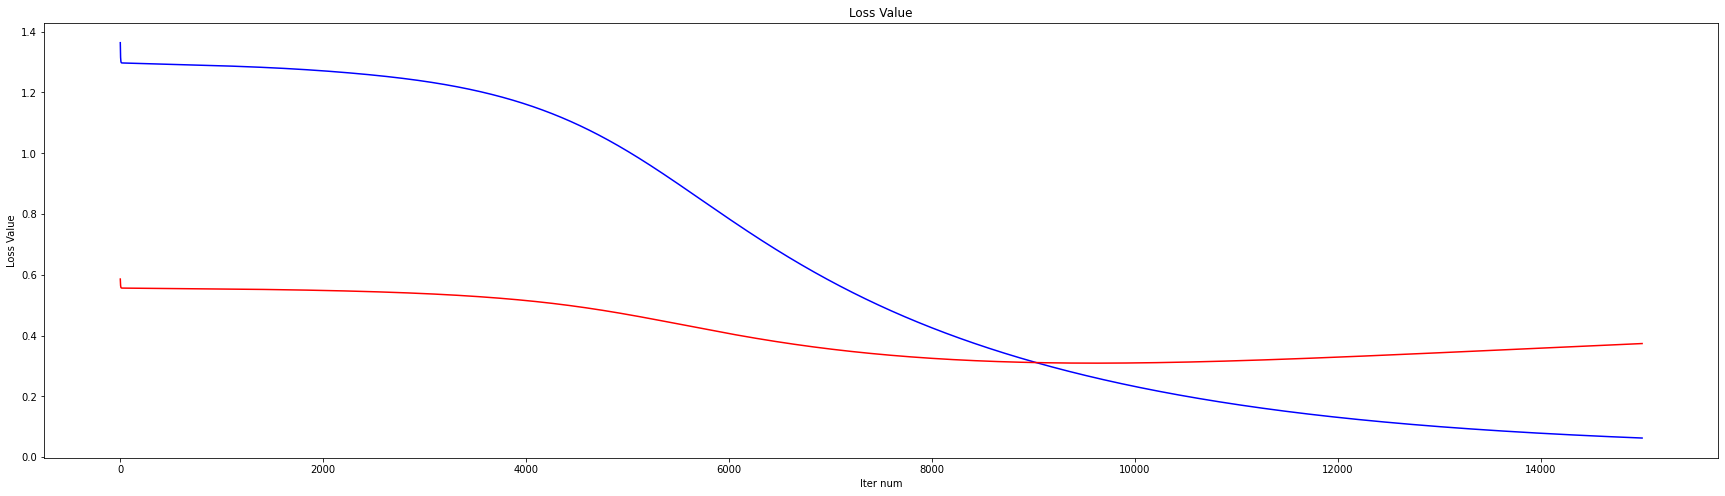

In [11]:
# Visualize of Loss Value
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 8))
plt.plot(range(len(lossList)), lossList, c='b')
plt.plot(range(len(lossTestList)), lossTestList, c='r')

plt.title('Loss Value')
plt.xlabel('Iter num')
plt.ylabel('Loss Value')
plt.show()

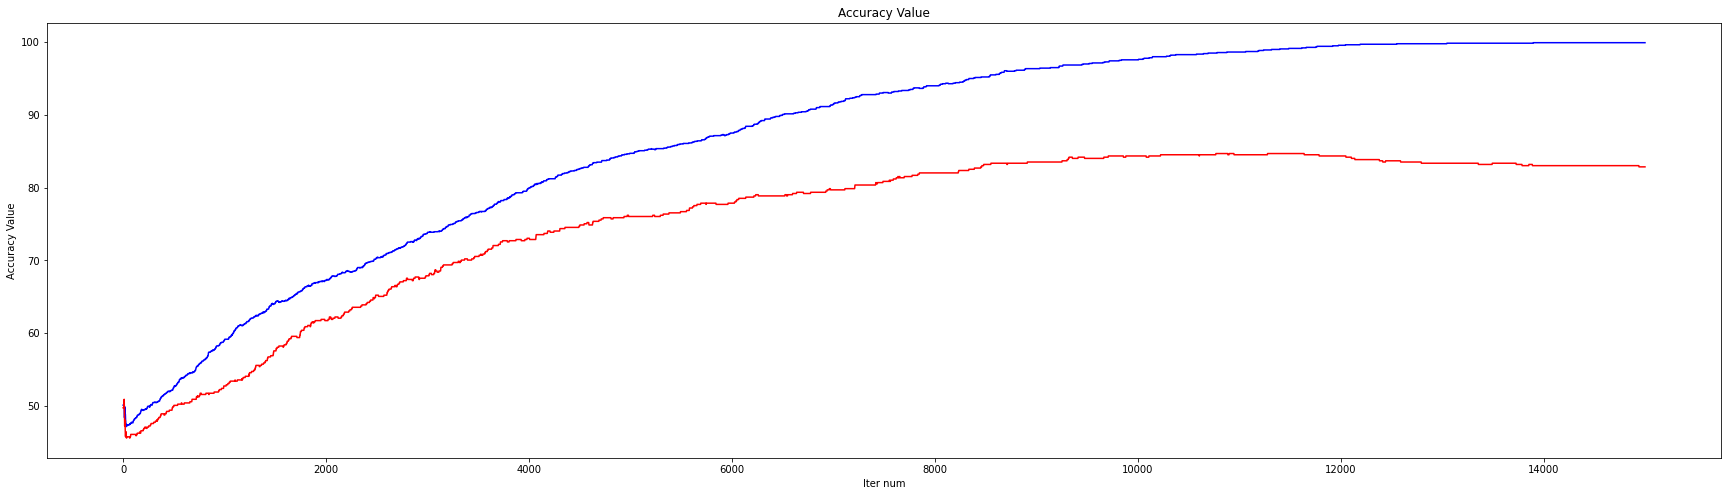

In [12]:
# Visualize of Accuracy
plt.figure(figsize=(30, 8))
plt.plot(range(len(accuracyList)), accuracyList, c='b')
plt.plot(range(len(testAccuracyList)), testAccuracyList, c='r')

plt.title('Accuracy Value')
plt.xlabel('Iter num')
plt.ylabel('Accuracy Value')
plt.show()

In [13]:
# Print the Final Accuracy
print("Training Data Accuracy : " + str(accuracyList[-1]))
print("Test Data Accuracy : " + str(testAccuracyList[-1]))

Training Data Accuracy : 99.92862241256245
Test Data Accuracy : 82.86189683860233


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_train,np.argmax(hSigmoidMatrix, axis = 0)))
print(classification_report(y_train,np.argmax(hSigmoidMatrix, axis = 0)))
print(accuracy_score(y_train, np.argmax(hSigmoidMatrix, axis = 0)))

print(confusion_matrix(y_test, np.argmax(hTestSigmoidMatrix, axis = 0)))
print(classification_report(y_test, np.argmax(hTestSigmoidMatrix, axis = 0)))
print(accuracy_score(y_test, np.argmax(hTestSigmoidMatrix, axis = 0)))

[[699   0]
 [  1 701]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       699
           1       1.00      1.00      1.00       702

    accuracy                           1.00      1401
   macro avg       1.00      1.00      1.00      1401
weighted avg       1.00      1.00      1.00      1401

0.9992862241256245
[[246  56]
 [ 47 252]]
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       302
           1       0.82      0.84      0.83       299

    accuracy                           0.83       601
   macro avg       0.83      0.83      0.83       601
weighted avg       0.83      0.83      0.83       601

0.8286189683860233
